In [1]:
from pathlib import Path
from PIL import Image

import numpy as np

import torch

from torch.utils.data import Dataset
from torchvision import datasets

from torch.utils.data import DataLoader

from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from emnist import NeuralNetwork, eminst_class

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork()
# model.load_state_dict(torch.load("model_weights.emnist.pth"))
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

/home/doodleduck/miniconda3/envs/rdkit310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [2]:
class CustomDataset(Dataset):
    def __init__(self, dir_path: str = '../tmp_img/'):
        super().__init__()
        self.image_list = []
        self.label_list = []
        for _dir in Path(dir_path).iterdir():
            for _img in Path(_dir).iterdir():
                self.image_list.append(_img)
                self.label_list.append(eminst_class.index(_dir.stem))
        self.transforms = A.Compose(
            [
                A.Resize(16, 16),
                A.ChannelShuffle(),
                A.Blur(blur_limit=(2, 2), always_apply=True),
                A.ShiftScaleRotate(
                    scale_limit=(-0.1, 0.1), rotate_limit=0, shift_limit=0, p=0.5
                ),
                # A.RandomBrightnessContrast(p=0.4),
                A.Normalize(mean=(0.5), std=(0.22), max_pixel_value=1),
                # A.Normalize(),
                ToTensorV2(),
            ]
        )

    def load_image(self, img_path):
        with Image.open(img_path) as pikybow_image:
            image = np.array(pikybow_image, dtype=np.uint8)
            # image = image.astype(np.float32)
            # image /= 255
        return image

    def __getitem__(
        self,
        index: int,
    ):
        image = self.load_image(self.image_list[index])
        label = self.label_list[index]
        transformed = self.transforms(image=image)
        image = transformed["image"]
        return image, label

    def __len__(self) -> int:
        return len(self.image_list)


In [58]:
import torch.nn.functional as F

def get_train_transform(image):
    image = np.array(image, dtype=np.uint8)
    # image = np.array(image, dtype=np.int16)
    # image -= 255
    # image *= -1
    # image = image.astype(np.uint8)[:, :, None].repeat(3, axis=2)
    x = train_transform(image=image)["image"]
    # x = F.pad(x, (2, 2, 2, 2), value=2.2727)
    return x


def get_test_transform(image):
    image = np.array(image, dtype=np.uint8)
    # image = np.array(image, dtype=np.int16)
    # image -= 255
    # image *= -1
    # image = image.astype(np.uint8)[:, :, None].repeat(3, axis=2)
    x = test_transform(image=image)["image"]
    # x = F.pad(x, (2, 2, 2, 2), value=2.2727)
    return x


train_transform = A.Compose(
    [
        A.Blur(blur_limit=(3, 5), p=0.4),
        A.Resize(14, 14),
        # A.ChannelShuffle(),
        A.HorizontalFlip(True),
        A.Rotate((90, 90), always_apply=True),
        A.RandomBrightnessContrast(p=0.4),
        A.GaussNoise((0, 255), 0, p=0.4),
        # A.CoarseDropout(4, 4, 4, 1, 1, 1, p=0.3),
        A.InvertImg(always_apply=True),
        A.Normalize(mean=(0.5), std=(0.22)),
        # A.Normalize(),
        ToTensorV2(),
    ]
)
test_transform = A.Compose(
    [
        A.Resize(14, 14),
        A.HorizontalFlip(True),
        A.Rotate((90, 90), always_apply=True),
        A.InvertImg(always_apply=True),
        A.Normalize(mean=(0.5), std=(0.22)),
        # A.Normalize(),
        ToTensorV2(),
    ]
)

In [59]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

def train(dataloader, model, loss_fn, optimizer, autocast_enabled):

    if autocast_enabled:
        scaler = GradScaler()

    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        optimizer.zero_grad()
        with torch.set_grad_enabled(True), autocast(enabled=autocast_enabled):
            pred = model(X)
            loss = loss_fn(pred, y)

            if not autocast_enabled:
                loss.backward()
                optimizer.step()
            else:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

training_data = datasets.EMNIST(
    split="byclass",
    # split='letters',
    root="../emnist_data",
    train=True,
    download=True,
    transform=get_train_transform,
)

test_data = datasets.EMNIST(
    split="byclass",
    # split='letters',
    root="../emnist_data",
    train=False,
    download=True,
    transform=get_test_transform,
)

train_dataloader = DataLoader(
    training_data, batch_size=1024, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_data, batch_size=1024, shuffle=True, num_workers=4
)

custom_training_data = CustomDataset()
custom_train_dataloader = DataLoader(
    custom_training_data, batch_size=10, shuffle=True, num_workers=1
)


In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

2


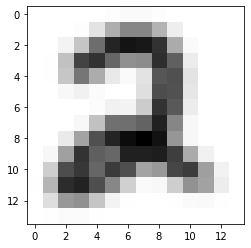

In [74]:
# i = 0
print(eminst_class[training_data[i][1]])
plt.imshow(training_data[i][0].permute(1, 2, 0).numpy(), cmap='gray')
i += 1

In [75]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # train(custom_train_dataloader, model, loss_fn, optimizer, True)
    train(train_dataloader, model, loss_fn, optimizer, True)
    test(test_dataloader, model, loss_fn)
    # if t % 5 == 0:
print("Done!")

Epoch 1
-------------------------------
loss: 4.604630  [    0/697932]
loss: 3.355000  [102400/697932]
loss: 2.320687  [204800/697932]
loss: 1.827979  [307200/697932]
loss: 1.538533  [409600/697932]
loss: 1.331674  [512000/697932]
loss: 1.148307  [614400/697932]
Test Error: 
 Accuracy: 71.6%, Avg loss: 1.005614 

Epoch 2
-------------------------------
loss: 1.169323  [    0/697932]
loss: 0.932814  [102400/697932]
loss: 0.945437  [204800/697932]
loss: 0.914555  [307200/697932]
loss: 0.884248  [409600/697932]
loss: 0.752508  [512000/697932]
loss: 0.816701  [614400/697932]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.679526 

Epoch 3
-------------------------------
loss: 0.786908  [    0/697932]
loss: 0.699120  [102400/697932]
loss: 0.653312  [204800/697932]
loss: 0.690941  [307200/697932]
loss: 0.664745  [409600/697932]
loss: 0.646918  [512000/697932]
loss: 0.681952  [614400/697932]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.592249 

Epoch 4
-------------------------------
loss: 0.702887 

In [76]:
# torch.save(model.state_dict(), "model_weights.fix.pth")
torch.save(model.state_dict(), "model_weights.emnist.pth")

In [ ]:
_idx = 0

In [ ]:
_x, y = custom_training_data[_idx]
x = _x.to(device)
y_hat = model(x[None])
print(eminst_class[y_hat.argmax()])
plt.imshow(_x.permute(1, 2, 0).numpy())

_idx += 3

# y_hat = y_hat.detach().cpu().numpy()